## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

2. Sudden flares of active galactic nuclei

3. Supernovae

(Check the figures on L11)


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

------
## My implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

### Data

In [3]:
# data acquisition
path = '/Users/giuliamariaborro/box/reps/astrostatistics_bicocca_2022/solutions/'
data = np.load(path + 'transient.npy')
print(data.shape)

time = data[:,0]
flux = data[:,1]
eflux = data[:,2]

(100, 3)


Text(0.5, 0, 'time')

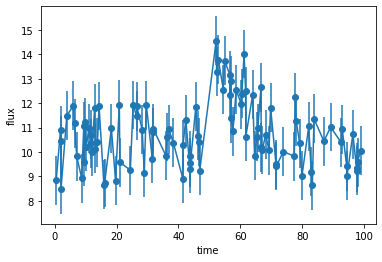

In [4]:
# plot the data with uncertainties
plt.scatter(time, flux)
plt.errorbar(time, flux, yerr = eflux)
plt.ylabel('flux')
plt.xlabel('time')

### Model

Build a model for this data.
We use a sharp burst with an exponential tail rising above a nominal background:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

with $b$ backround level, $A$ burst amplitude, $t_0$ burst epoch, $\alpha$ burst die off.

In [5]:
# burst model: b backround level, A burst amplitude, to burst epoch, alpha burst die off
def burst(par, t):
    b, A, alpha, to = par 
    return np.where(t < to, b, b + A * np.exp(-alpha*(t-to)))  # shortcut for 'if t<to return b, else return b+...'

In [6]:
# FIT THE DATA

# parameters eaten by the model
b, A, alpha, to = 10, 5, 0.1, 50
par = [b, A, alpha, to]

# model
fluxfit = burst(par, time)

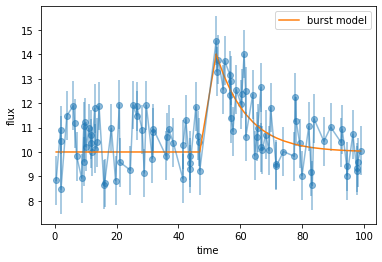

In [7]:
plt.scatter(time, flux, alpha=0.5)
plt.errorbar(time, flux, yerr = eflux, alpha=0.5)
plt.plot(time, fluxfit, label='burst model')
plt.legend()
plt.ylabel('flux')
plt.xlabel('time');

### Likelihood

Doing the log the non-costant part of the model we get:

$\ln y = \ln b + \ln A -\alpha(t-t_0)$,

which is like having a linear relationship with residuals:

$y_i = b + at_i + r_i.$

If I assume scatter is generated from a Gaussian process, then the logLikelihood is:

$\ln L = const -\frac{1}{2}\Sigma\left(\frac{y_i - M(y_i)}{\sigma_i}\right)^{2},$

where $M(a,b)$ is the model for $y$.

In [8]:
def logLikelihood(par, data):
    x, y, erry = data.T
    My = burst(par, x)
    return - 0.5 * np.sum((y-My)**2/(erry**2))   

### MCMC with emcee

At first I need to define the Likelihhod (already done) and the Prior. 
By evaluating them at each point I get the Posterior that required in emcee algorithm. 

#### Prior

Prior is the product of priors (logPrior is the sum of logPriors).

I take it Uniform for $b$, $A$, $to$ and $\ln(\alpha)$.

Priors for $b$, $A$, $to$ are thus just constants. 
Prior for $\alpha$ is:

$$P(\alpha) = \frac{d\ln\alpha}{d\alpha} \times P(\ln\alpha) = \frac{1}{\alpha} const.$$

Doing the log i get:
$$ \ln Prior(\alpha) = - \ln\alpha + const.$$

I sum all the priors and ignore the constants obtaining that the prior is:

$$ \ln Prior = - \ln\alpha $$

inside the ranges of the uniform.

Outside the uniforms instead the prior is 0, thus $$\ln Prior = -\infty.$$

In [9]:
def logPrior(par):
    b, A, alpha, to = par
    if 0 < b < 50 and 0 < A < 50 and np.exp(-5) < alpha < np.exp(5) and 0 < to < 100:
        return - np.log(alpha)  
    else: 
        return -np.inf

#### Posterior

In [10]:
def logPosterior(par, data):
    return logPrior(par) + logLikelihood(par, data)

#### emcee

In [11]:
ndim = 4         # number of parameters in the model
nwalkers = 20    # number of walkers
nsteps = 8000    # steps for each walker


# initialize parameters 
P0 = par + np.random.random((nwalkers, ndim))/10  
print(P0.shape, '\n',P0)

#-----------------------
#/10 otherwise trace plots get stuck, 
# especially for alpha where having 0.1 or 1. makes a big difference
# ha senso giusto? come è legato al sigma questo? 

(20, 4) 
 [[10.00228328  5.07193378  0.15625581 50.04714651]
 [10.00768256  5.03384825  0.11358452 50.02382532]
 [10.07331329  5.01137448  0.11804992 50.09308091]
 [10.0238891   5.01250106  0.19207166 50.01043457]
 [10.01170197  5.05140056  0.16556934 50.02921577]
 [10.01287403  5.02875286  0.18406703 50.0822807 ]
 [10.08345605  5.0610692   0.13768025 50.09090393]
 [10.07265214  5.06374295  0.14529586 50.05621232]
 [10.08843597  5.06633749  0.11249754 50.05861844]
 [10.09130214  5.03952163  0.10529476 50.04326285]
 [10.0505518   5.06740707  0.17165345 50.01088747]
 [10.09920527  5.08733612  0.1216874  50.04899815]
 [10.00274195  5.01689237  0.16914987 50.00638535]
 [10.09896779  5.0800152   0.18549069 50.01830634]
 [10.09453929  5.06672539  0.17621509 50.08348867]
 [10.0466393   5.02805486  0.12194214 50.04801722]
 [10.04843702  5.02225054  0.1207556  50.09925423]
 [10.01135317  5.00241967  0.14791616 50.03344622]
 [10.07575451  5.04619298  0.10959455 50.0949489 ]
 [10.06756397  5.0333

In [12]:
#MCMC 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[data])  #sampler
result = sampler.run_mcmc(P0, nsteps)   
print(result)  # to get what .run_mcmc returns

State([[10.23617778  5.76952885  0.13312016 49.97966023]
 [10.32409919  5.00823242  0.13688134 48.91240979]
 [10.28042353  5.7592915   0.11314609 46.96154871]
 [10.09206398  4.44460883  0.08908069 50.81961349]
 [10.38617239  5.15167927  0.16006662 50.53916116]
 [10.2760304   4.76285986  0.13738983 52.1476218 ]
 [10.36145831  3.96277323  0.1566298  51.27108538]
 [10.38777691  5.0767227   0.11880332 49.38459224]
 [10.4430292   4.72259243  0.11303749 48.36728929]
 [10.06048689  7.10543142  0.1220782  47.58919818]
 [10.34010159  6.64495011  0.14136471 48.20975164]
 [10.24216931  5.15322151  0.11037973 48.82010789]
 [10.20904585  5.75547817  0.11298646 48.93144252]
 [10.21629825  9.22022055  0.15202699 47.33311238]
 [10.15737294  4.76675843  0.10732189 52.14301419]
 [10.30612439  6.88321946  0.12995321 47.2649729 ]
 [10.48676259  4.54789899  0.15419315 50.67725748]
 [10.41744663  5.63276791  0.11711035 47.41798199]
 [10.20571745  4.4770548   0.09521765 49.38751275]
 [10.31989247  7.41407255

In [13]:
# okay, i get the MCMC samples
samples = sampler.get_chain()
print(samples.shape)

(8000, 20, 4)


### Thin the chain

I check at trace plots to understand the burn-in

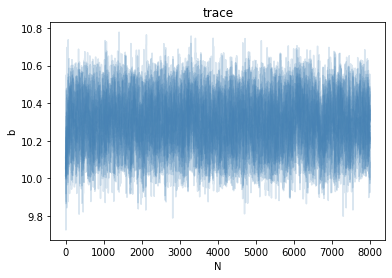

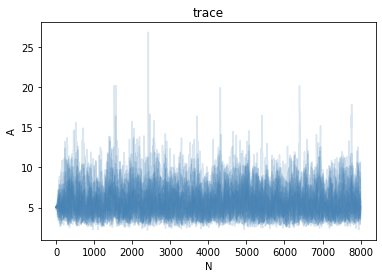

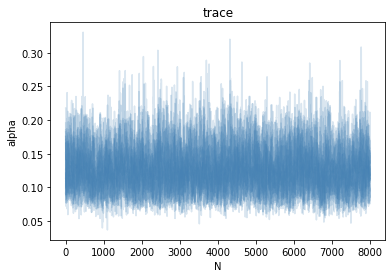

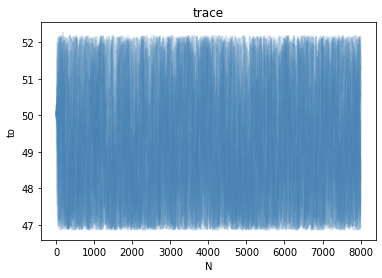

<Figure size 432x288 with 0 Axes>

In [14]:
labels = ['b', 'A', 'alpha', 'to' ]
for i in range(0, ndim):
    plt.plot(samples[:, :, i], alpha=0.2, color = 'steelblue')
    plt.title('trace')
    plt.xlabel('N')
    plt.ylabel(labels[i])
    plt.show()
    plt.clf()

In [15]:
# let's compute how much time a point needs to have memory lack 
tau = sampler.get_autocorr_time()
print(tau)

[56.32255946 71.40307122 55.28715401 78.42821106]


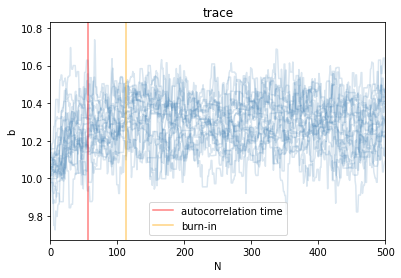

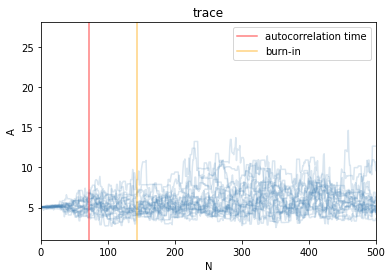

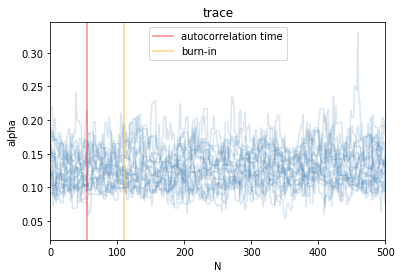

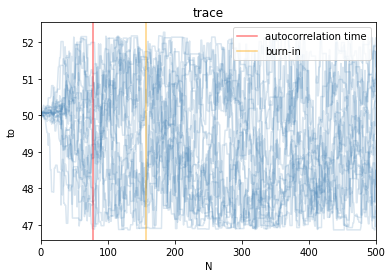

<Figure size 432x288 with 0 Axes>

In [16]:
# decide the burn-in on the plots
labels = ['b', 'A', 'alpha', 'to' ]
for i in range(0, ndim):
    plt.plot(samples[:, :, i], alpha=0.2, color = 'steelblue')
    plt.title('trace')
    plt.xlabel('N')
    plt.ylabel(labels[i])
    plt.axvline(tau[i], color='red', alpha=0.5, label='autocorrelation time')
    #from the plot with the red line I see I want to discard more than what tau tells me...
    #let's see if twice tau it's good
    plt.axvline(tau[i]*2, color='orange', alpha=0.5, label='burn-in')
    plt.xlim(0, 500)
    plt.legend()
    plt.show()
    plt.clf()

In [17]:
burnin = int(max(tau)*2)   # remove the first points
al = int(max(tau))         # select points every autocorrelation length

# THIN THE SAMPLE
thinsamples = sampler.get_chain(discard = burnin, thin = al)   
print(thinsamples.shape)  

# flatten the samples taken for each walker in a single sample 
flatsamples = sampler.get_chain(discard = burnin, thin = al, flat=True)
print(flatsamples.shape)   # if too low increase nsteps

(100, 20, 4)
(2000, 4)


### Posteriors

Corner plot of the 4D parameter space

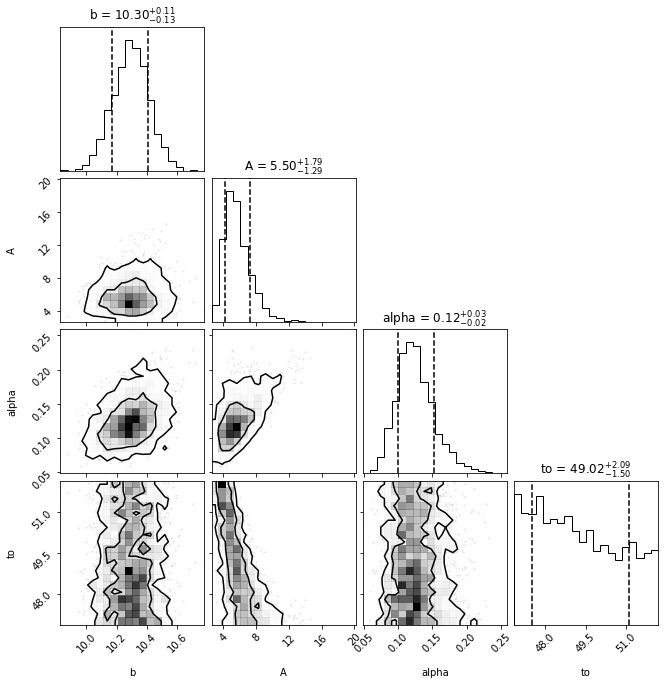

In [18]:
# 68 and 95 credible levels, 0.16 and 0.84 quantiles (so that area inside is 0.68)
figure = corner.corner(flatsamples, labels=labels, 
                       levels = [0.68, 0.95], quantiles=[0.16, 0.84],
                       show_titles=True)

Now we take 100 random samples par = (b, A, alpha, to) from my burned and thinned data.
For each of these I plot the model and see the posterior spread of model solutions that are consistent with data

(100, 4)


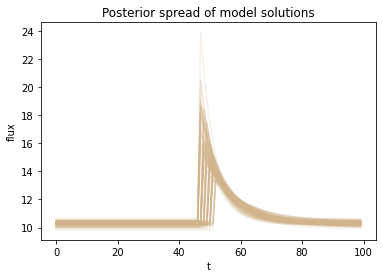

In [19]:
# choose 100 samples randomly from burned & thinned chain
samples100 = flatsamples[np.random.choice(range(len(flatsamples)), 100)]
print(samples100.shape);


# I fit the model with the 4 random parameters obtained each time (so I get 100 models)
t = np.linspace(0, 100, 100)
mcmc_flux = np.array([burst(par, t) for par in samples100])


# plot the model
for i in range(len(mcmc_flux)):
    plt.plot(mcmc_flux[i], color='tan', alpha=0.2)    #posterior spread of model solutions consistent with data
    plt.title('Posterior spread of model solutions')
    plt.xlabel('t')
    plt.ylabel('flux')

Text(0.5, 1.0, 'Posterior spread & data')

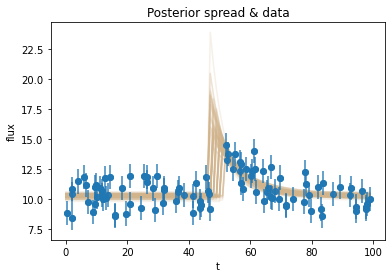

In [20]:
# now we see it with all the data 
for i in range(len(mcmc_flux)):
    plt.plot(mcmc_flux[i], color='tan', alpha=0.2)

plt.scatter(time, flux, alpha=0.9)
plt.errorbar(time, flux, yerr = eflux, fmt='o', alpha=0.9)
plt.xlabel('t')
plt.ylabel('flux')
plt.title('Posterior spread & data')

### Estimate the parameters 

I estimate parameters using the median and the 90% credible region 

In [21]:
# save the values to plot them in the hist later
median = []
quantile95 = []
quantile05 = []


for i in range(len(par)):
    
    # save the values in lists  
    median.append(np.median(flatsamples[:, i]))
    quantile95.append(np.quantile(flatsamples[:, i], 0.95)) 
    quantile05.append(np.quantile(flatsamples[:, i], 0.05)) 
     
    # upper and lower labels for 90% credible region
    up = quantile95[i]-median[i]        
    low = median[i]-quantile05[i]
    
    print(labels[i], '=', str(round(median[i],2)),'+', str(round(up,2)), '-', str(round(low,2)))


b = 10.3 + 0.2 - 0.2
A = 5.5 + 3.36 - 1.87
alpha = 0.12 + 0.06 - 0.04
to = 49.02 + 2.83 - 1.98


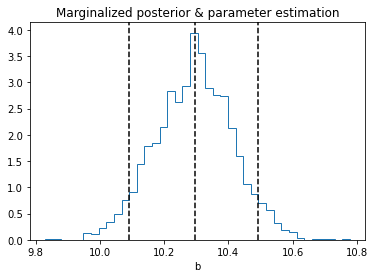

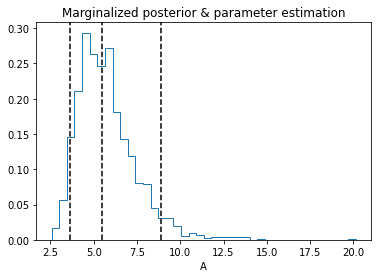

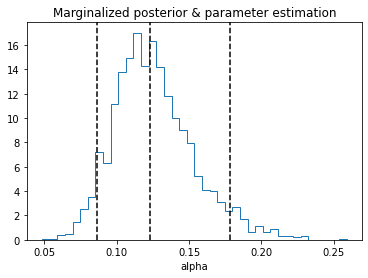

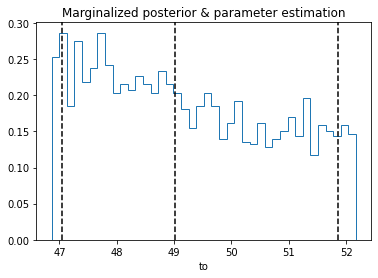

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(len(par)):
    plt.hist(flatsamples[:,i], bins=40, histtype='step', density=True)
    plt.axvline(median[i], color='black', linestyle='--')
    plt.axvline(quantile95[i], color='black', linestyle='--')
    plt.axvline(quantile05[i], color='black', linestyle='--')
    
    plt.title('Marginalized posterior & parameter estimation')
    plt.xlabel(labels[i])
    
    plt.show()
    plt.clf()